<a href="https://colab.research.google.com/github/Rishabh672003/stack-overflow-label-predictor/blob/main/Stack_Overflow_label_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming question's Language Classifier

Most forums and programming platform have tags to classify questions, Many sites leave this for user asking question to do manually, but we can also this with the help of AI.

Thats what this model is supposed to do, classify the question asked by the user by programming languages.

In [48]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.saving import register_keras_serializable

## Dataset

The dataset we have used is of StackOverflow which is a popular site to ask questions

The dataset has questions for 4 languages -
1. Csharp
2. Java
4. Python

Each language has around 2000 question in training Set and also 2000 in testing set

In [49]:
url = "https://github.com/Rishabh672003/stack-overflow-label-predictor/raw/main/datasets/stack_overflow_16k-full.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k-full", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k-full')

In [50]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [51]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['javascript', 'csharp', 'java', 'python']

In [52]:
sample_file = os.path.join(train_dir, 'csharp/1.txt')
with open(sample_file) as f:
  print(f.read())

"get the y axis height of webbrowser control document i am trying to get the height of a document in a web browser control...at the moment i'm using the code below but it always returns 622 and i know my documents are all different sizes...private void webcomparesql_documentcompleted(object sender, webbrowserdocumentcompletedeventargs e).        {.            htmldocument htmldoc = webcomparesql.document;.           int scrollhight = htmldoc.window.position.y;.        }...can someone please show me the right way to do this?"



### We use `tf.keras.utils.text_dataset_from_directory` to load dataset from the directory and split 20% for validation

In [53]:
batch_size = 32
seed = 42

# This is for training dataset
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k-full/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)
raw_train_ds

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [54]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(4):
    print("Question", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

2024-07-30 19:52:15.175262: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [55]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[2])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to javascript


In [56]:
# this is for validation dataset
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k-full/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [57]:
# This is for testing dataset
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k-full/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Prepare the dataset for training

Next, we will **standardize**, **tokenize**, and **vectorize** the data using the `tf.keras.layers.TextVectorization` layer.

**Standardization** refers to preprocessing the text, typically to **remove punctuation** or **HTML** elements to simplify the dataset.

**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

In [58]:
@register_keras_serializable(package="Custom", name="custom_standardization")
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, We will create a **TextVectorization** layer. we will use this layer to standardize, tokenize, and vectorize our data. we set the output_mode to int to create unique integer indices for each token.

We're using the default split function, and the custom standardization function we defined above. we'll also define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.

In [59]:
max_features = 3000
sequence_length = 300

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [60]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

And you can see in the output what the vectorization outputs

In [61]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [62]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70,    1,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

The result of our vectorization:

In [63]:
print("128 ---> ",vectorize_layer.get_vocabulary()[128])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

128 --->  result
 313 --->  source
Vocabulary size: 3000


 ### As a final preprocessing step, we will apply the TextVectorization layer we created earlier to the train, validation, and test dataset.

In [64]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Some performance optimization

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training or model. It makes a high performance cache of the dataset

`.prefetch()` overlaps data preprocessing and model execution while training.

In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the model

In [66]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

In [68]:
epochs = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose = 1, patience=5, restore_best_weights=True)
r = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[callback],
    epochs=epochs)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2885 - loss: 1.3818 - val_accuracy: 0.2744 - val_loss: 1.3673
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3663 - loss: 1.3526 - val_accuracy: 0.3338 - val_loss: 1.3299
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4473 - loss: 1.3124 - val_accuracy: 0.4938 - val_loss: 1.2692
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5321 - loss: 1.2515 - val_accuracy: 0.6356 - val_loss: 1.1923
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5933 - loss: 1.1793 - val_accuracy: 0.6637 - val_loss: 1.1179
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6153 - loss: 1.1078 - val_accuracy: 0.6781 - val_loss: 1.0465
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6344 - loss: 1.0444 - val_accuracy: 0.6956 - val_loss: 0.9901
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6666 - loss: 0.9864 - val_accuracy: 0.

In [69]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7845 - loss: 0.5697
Loss:  0.5722776055335999
Accuracy:  0.7806249856948853


## Plotting the results of our Model

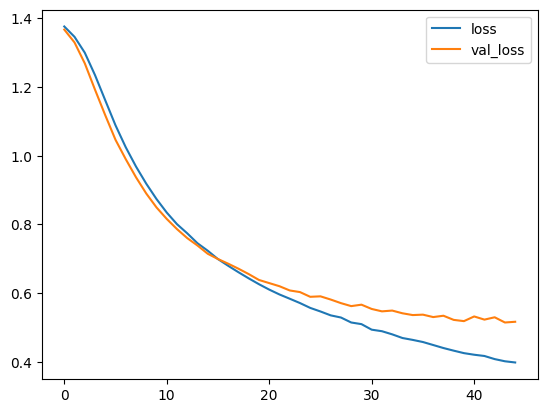

In [70]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

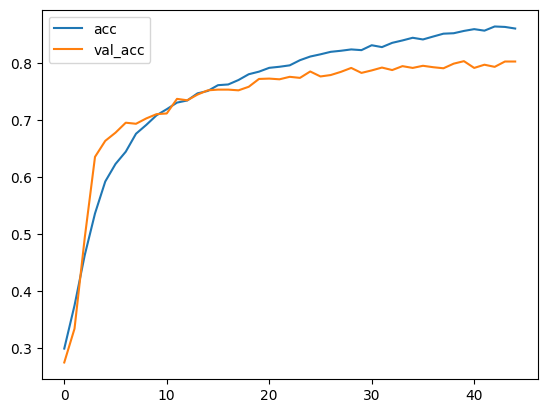

In [71]:
plt.plot(r.history['accuracy'], label = "acc")
plt.plot(r.history['val_accuracy'], label = "val_acc")
plt.legend();

#### Confusion Matrix

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[[458 466 588 488]
 [446 452 595 507]
 [456 435 612 497]
 [489 439 551 521]]


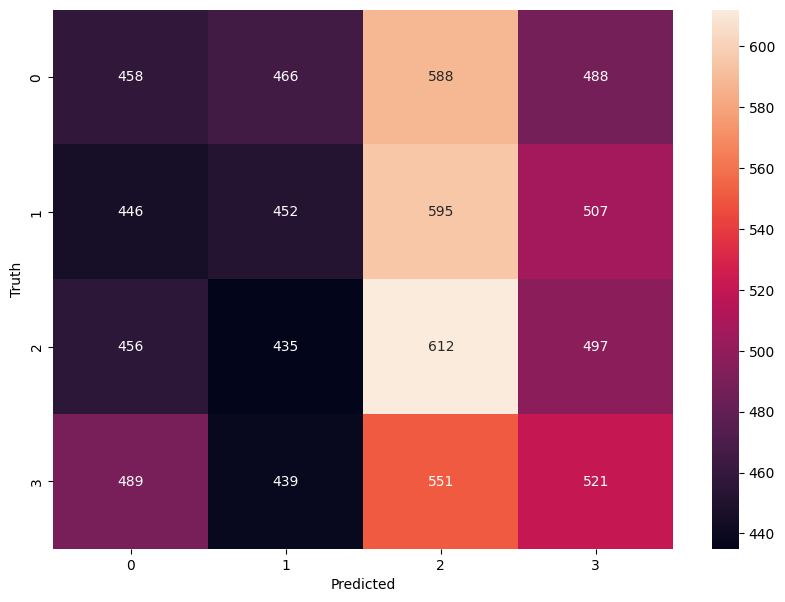

In [72]:
predictions = model.predict(test_ds)

predicted_labels = np.argmax(predictions, axis=-1)

actual_labels = []
for _, label in raw_test_ds:
  actual_labels.extend(label.numpy())

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(actual_labels, predicted_labels).numpy()

# Print the confusion matrix
print(confusion_mtx)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## Exporting the Model for working with Raw text

In [75]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=['accuracy']
)

In [76]:
# Test it with `raw_test_ds`, which yields raw strings
accuracy = export_model.evaluate(raw_test_ds)
print(export_model.metrics_names)
print(accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7859 - loss: 0.0000e+00
['loss', 'loss', 'compile_metrics', 'compile_metrics']
[0.0, 0.0, 0.7806249856948853, 0.7806249856948853]


In [77]:
export_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 300)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 4)              │        48,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,068 (187.77 KB)

 Trainable params: 48,068 (187.77 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
labels = ["Csharp","Java", "Javascript" ,"Python"]
examples = tf.constant([
  "Why can't this generic method return concrete class that implements it's interface?",
  "I have a dictionary of size n and i want to double its size and put 0:0 in the remaining spots",
  "Restsharp 110.2 returns 401 with Basic Authentication",
  "How to make good reproducible pandas examples, a = 12 import pandas as pd",
])

predictions = export_model.predict(examples)

# Display the predictions
print(predictions)

for i in range(0,len(examples)):
  label = np.argmax(predictions[i])
  print(labels[label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.56854147 0.66359305 0.48026904 0.23555554]
 [0.55577326 0.4706442  0.47378924 0.46983013]
 [0.5048865  0.4227807  0.6877464  0.3762881 ]
 [0.28164962 0.53825784 0.52491    0.7512016 ]]
Java
Csharp
Javascript
Python


In [85]:
export_model.save('./NLP-model.keras')

# Making a FAST API website with our model

In [31]:
from fastapi import FastAPI, Request, Form
from fastapi.responses import HTMLResponse
from fastapi.templating import Jinja2Templates
import uvicorn
import re
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np

import numpy as np
import tensorflow as tf

from pydantic import BaseModel

app = FastAPI()

templates = Jinja2Templates(directory="templates")


@app.post("/submit", response_class=HTMLResponse)
async def submit(request: Request, text: str = Form(...)):
    # Process the input text
    processed_text = predictor(text)
    return templates.TemplateResponse(
        "index.html",
        {"request": request, "processed_text": processed_text, "text": text},
    )


@app.get("/", response_class=HTMLResponse)
async def index(request: Request):
    return templates.TemplateResponse("index.html", {"request": request})


class TextInput(BaseModel):
    text: str


@app.post("/echo")
async def echo(input: TextInput):
    print(input)
    return {"text": input.text}


@app.get("/ping")
async def ping():
    return "Server Up and running"


# Define the custom standardization function
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape(string.punctuation), ""
    )


# Load the model with the custom standardization function
loaded_model = tf.keras.models.load_model(
    "./NLP-model",
    custom_objects={"custom_standardization": custom_standardization},
)


def predictor(input):
    labels = ["Csharp", "Java", "Javascript", "Python"]
    examples = [input]

    answers = loaded_model.predict(examples)
    label = np.argmax(answers)
    return labels[label]


if __name__ == "__main__":
    uvicorn.run(app, host="localhost", port=8082)


ModuleNotFoundError: No module named 'fastapi'

## Index.html

```html
<!doctype html>
<html>
  <head>
    <script src="https://cdn.tailwindcss.com"></script>
    <style>
    body {
      display: flex;
      flex-direction: column;
      justify-content: center;
      align-items: center;
      min-height: 100vh;
      background-color: #f0f0f0;
      font-family: Arial, sans-serif;
    }

    form {
      background-color: #fff;
      padding: 20px;
      border-radius: 5px;
      box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.1);
    }

    label {
      display: block;
      margin-bottom: 10px;
    }

    input[type="text"] {
      width: 100%;
      padding: 10px;
      margin-bottom: 20px;
      border-radius: 5px;
      border: 1px solid #ddd;
    }

    input[type="submit"] {
      background-color: #007bff;
      color: white;
      padding: 10px 20px;
      border: none;
      border-radius: 5px;
      cursor: pointer;
    }

    input[type="submit"]:hover {
      background-color: #0056b3;
    }

    p {
      margin-top: 20px;
    }

    .output {
      background-color: #f0f0f0;
      padding: 20px;
      border-radius: 5px;
      box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.1);
      margin-top: 20px;
    }
</style>
  </head>
  <body>
    <form action="/submit" method="post">
      <label for="text">Enter Question:</label>
      <input type="text" id="text" name="text" />
      <input type="submit" value="Submit" />
    </form>
    {% if processed_text %}
    <div class="output">
      <p>
        Your Question was: {{ text }}<br />
        <br />
        Model predicted the question is for following language: {{
        processed_text }}
      </p>
    </div>
    {% endif %}
  </body>
</html>
```